# Finding potential fragment merges with the Fragment Network

This notebook illustrates how to use the Fragment Network to find purchasable molecules that
combine parts of two fragments.

For information about the Fragment Network see:
* [doi:10.1021/acs.jmedchem.7b00809](https://pubs.acs.org/doi/10.1021/acs.jmedchem.7b00809)
* https://fragnet.informaticsmatters.com/

The assumption is that you have 2 fragment screening hits that are partly overlapping in space.
You want to identify purchasable molecules that might be *best of both worlds* in forming interactions
from both fragments.

We use the term "synthon" to mean a fragment of a molecule in the context of the Fragment Network.
We use this term rather than fragment to avoid confusion with the use of that name in fragment screening. 

The approach is to:
* Identify the synthons of fragment B that you want to graft onto fragment A 
* Start from fragment A and optionally add one synthon of any type (mols1)
* For those molecules optionally remove one synthon(mols2)
* For each synthon from fragment B add it to each of mols2 (mols3)

Where we state remove a synthon we mean find molecules in the Fragment Network that is a direct child of the source molecule.
Where we state add a synthon we mean find molecules in the Fragment Network that is a direct parent of the source molecule.

The result is a set of molecules derived from fragment A, possibly missing one synthon, having one synthon from fragment B added and possibly having one extra synthon of any type added.

One a small subset of these will be able to take up favourable conformations that are compatible with forming the relevent interactions formed by fragments A and B. This has to be checked using subsequent 3D techniques. 

## Usage

To use this you must have a Fragment Network Neo4j database running on your machine.

Typically do this with one of our [test containers](https://github.com/InformaticsMatters/docker-fragnet-test)
of by using `kubect port-forward ...` to access a real database running in K8S. 

In [33]:
from neo4j import GraphDatabase
from rdkit import Chem
from rdkit.Chem import Draw

In [34]:
# prompt for the database password
import getpass
try:
    password
except NameError:
    password = getpass.getpass()

In [35]:
# simple test to make sure RDKit is operational
m = Chem.MolFromSmiles('ClC1CCC(C(N)C)CC1')
Chem.MolToSmiles(m)

'CC(N)C1CCC(Cl)CC1'

In [36]:
driver = GraphDatabase.driver("bolt://localhost:7687", auth=("neo4j", password))

In [37]:
# simple example of a finding a molecule using its SMILES
def find_molecule_node(tx, smiles):
    for record in tx.run('MATCH (m:F2 {smiles: $smiles}) RETURN m', smiles=smiles):
        node = record['m']
        return node

In [38]:
def mols_from_smiles(smiles):
    mols = [Chem.MolFromSmiles(s) for s in smiles ]
    return mols

## Parameters

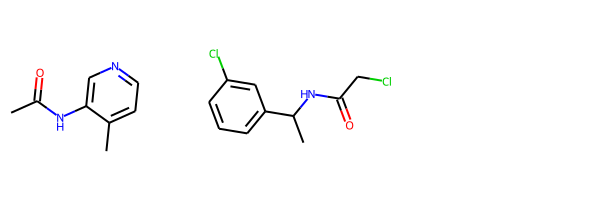

In [39]:
x0107 = 'CC(=O)Nc1cnccc1C'
x0397 = 'Cc1cc(CN(C)C(=O)NC2CC2)no1'
x0434 = 'O=C(Nc1ccccc1)Nc1cccnc1'
x0874 = 'NC(=O)[C@H]1CCC[C@H]1c1ccsc1' # not present
x1093 = 'CN1CCN(C(=O)Cc2c[nH]c3ncccc23)CC1'
x1382 = 'CC(NC(=O)CCl)c1cccc(Cl)c1'
x2646 = 'Cc1ccncc1NC(=O)Cc1cccc(Cl)c1' # TRY-UNI-714a760b-6

fragment_a = x0107
fragment_b = x1382

mol_a = Chem.MolFromSmiles(fragment_a)
mol_b = Chem.MolFromSmiles(fragment_b)

Draw.MolsToGridImage([mol_a, mol_b])

## Verify that those fragments are in the fragment network database

In [40]:
with driver.session() as session:
    mol = session.read_transaction(find_molecule_node, fragment_a)
    print(mol)

<Node id=542708467 labels=frozenset({'F2', 'V_MP', 'M_x0107_CeeP', 'CanSmi', 'M_x0107_CeP', 'V_REAL', 'Mol', 'V_XDSIP'}) properties={'smiles': 'CC(=O)Nc1cnccc1C', 'inchik': 'WRPYDRDMRXJIJA-KZFATGLANA-N', 'osmiles': 'CC(O)NC1CCCCC1C', 'chac': 6, 'hac': 11, 'inchis': 'InChI=1/C8H10N2O/c1-6-3-4-9-5-8(6)10-7(2)11/h3-5H,1-2H3,(H,10,11)/f/h10HMA', 'cmpd_ids': ['MOLPORT:003-985-997', 'XCHEM:Z1129283193', 'REAL:Z1129283193']}>


In [41]:
with driver.session() as session:
    mol = session.read_transaction(find_molecule_node, fragment_b)
    print(mol)

<Node id=530244989 labels=frozenset({'F2', 'V_CS_BB', 'V_MP', 'M_x1382_CeeP', 'CanSmi', 'Mol', 'M_x1382_CeP'}) properties={'smiles': 'CC(NC(=O)CCl)c1cccc(Cl)c1', 'inchik': 'IPGDMBWEYHBLRL-NDKGDYFDNA-N', 'osmiles': 'CC(NC(O)CCl)C1CCCC(Cl)C1', 'chac': 6, 'hac': 14, 'inchis': 'InChI=1/C10H11Cl2NO/c1-7(13-10(14)6-11)8-3-2-4-9(12)5-8/h2-5,7H,6H2,1H3,(H,13,14)/f/h13HMA', 'cmpd_ids': ['CHEMSPACE-BB:CSMB00012906349', 'CHEMSPACE-BB:CSMB00012906358', 'MOLPORT:002-466-937']}>


## Child synthons
Methods to find all child synthons of a molecule. The edges have a 'label' property that looks like this:

`RING|[Xe]c1nncs1|[103Xe]C1CCCC1|RING|O=C(Cc1c[nH]c2ncccc12)N1CCN(C[Xe])CC1|OC(CC1CCC2CCCCC12)C1CCC(C[103Xe])CC1`

This has six tokens.
The second token describes what was added/removed.
The fith token describes what it was added/removed to/from.
Both use a Xe atom to mark the attachment site.
Hence those two tokens can be considered potential *synthons*.
They have to be filtered to remove molecules with 2 components and those with 2 attachements sites as those are
not able to make simple adducts.

In [42]:
def add_required_synthons(labels, synthon):
    """Only add synthons with a single attachment point and a single component"""
    if synthon.count('[Xe]') > 0:
        labels.add(synthon)

def find_synthons(tx, smiles):
    """Query for all child fragments (recursive).
    Extract the label property of each edge and collect a set of SMILES that match our needs.
    """
    labels = set()
    for record in tx.run('MATCH (fa:F2 {smiles: $smiles})-[e:FRAG*]->(f:F2) RETURN e', smiles=smiles):
        edges = record['e']
        for edge in edges:
            s = edge['label']
            tokens = s.split('|')
            #print('Found', tokens[1], tokens[4])
            add_required_synthons(labels, tokens[1])
            add_required_synthons(labels, tokens[4])
    return list(labels)

Found 7 synthons
Clc1cccc([Xe])c1
CC(NC(=O)CCl)c1cccc([Xe])c1
CC([Xe])NC(=O)CCl.Cl[Xe]
Cl[Xe]
[Xe]c1cccc([Xe])c1
CC([Xe])NC(=O)CCl
[Xe]c1ccccc1


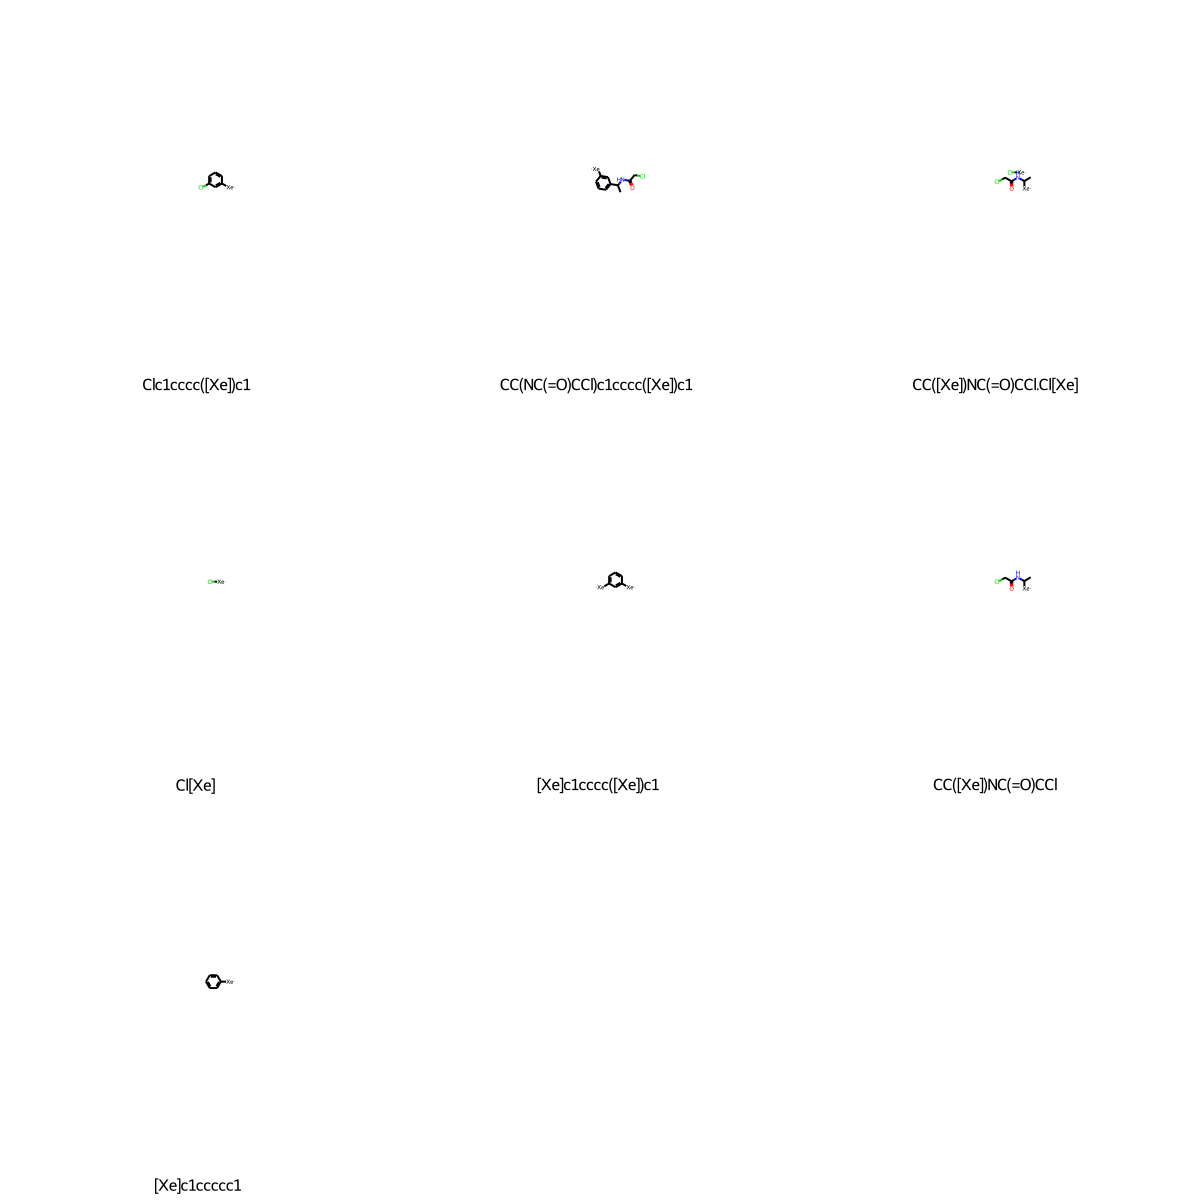

In [43]:
# Generate synthons or fragment B
with driver.session() as session:
    synthons = session.read_transaction(find_synthons, fragment_b)
    print('Found', len(synthons), 'synthons')
    for s in synthons:
        print(s)

Draw.MolsToGridImage(mols_from_smiles(synthons), legends=synthons, subImgSize=(400, 400))

## Expand fragment A

In [44]:
query = ("MATCH (fa:F2 {smiles: $smiles})"
        "-[:FRAG*0..2]-(:F2)"
        "<-[e:FRAG]-(c:Mol) WHERE"
        " c.hac > 15 AND"
        " (split(e.label, '|')[1] = $synthon OR split(e.label, '|')[4] = $synthon)"
        " RETURN DISTINCT c")
print('Cypher Query:')
print(query)

def find_expansions(tx, smiles, synthon):
    """Expand the molecules with this SMILES using this synthon"""
    expansions = set()
    for record in tx.run(query, smiles=smiles, synthon=synthon):
        node = record['c']
        expansions.add(node['smiles'])
    return expansions

Cypher Query:
MATCH (fa:F2 {smiles: $smiles})-[:FRAG*0..2]-(:F2)<-[e:FRAG]-(c:Mol) WHERE c.hac > 15 AND (split(e.label, '|')[1] = $synthon OR split(e.label, '|')[4] = $synthon) RETURN DISTINCT c


In [45]:
%%time
# do the expansions

print('Fragment A:', fragment_a)
print('Fragment B:', fragment_b)
print('Query:', query)
data = []
synthon_mols = []
with driver.session() as session:
    count = 0
    synthon_no = 0
    expanded_synthons = 0
    # for each synthon
    for synthon in synthons:
        synthon_mol = Chem.MolFromSmiles(synthon)
        synthon_mols.append(synthon_mol)
        synthon_data = []
        data.append(synthon_data)
        # do the expansion of fragment_a with that synthon
        print('Running synthon', synthon_no, synthon)
        expansions = session.read_transaction(find_expansions, fragment_a, synthon)
        print('Found', len(expansions), 'expansions')
        count += len(expansions)
        if (len(expansions)):
            expanded_synthons += 1
        for e in expansions:
            #print(e)
            synthon_data.append(e)
        synthon_no += 1
        
    print(count, 'total expansions from', expanded_synthons, 'out of', len(synthons), 'synthons')

Fragment A: CC(=O)Nc1cnccc1C
Fragment B: CC(NC(=O)CCl)c1cccc(Cl)c1
Query: MATCH (fa:F2 {smiles: $smiles})-[:FRAG*0..2]-(:F2)<-[e:FRAG]-(c:Mol) WHERE c.hac > 15 AND (split(e.label, '|')[1] = $synthon OR split(e.label, '|')[4] = $synthon) RETURN DISTINCT c
Running synthon 0 Clc1cccc([Xe])c1
Found 0 expansions
Running synthon 1 CC(NC(=O)CCl)c1cccc([Xe])c1
Found 0 expansions
Running synthon 2 CC([Xe])NC(=O)CCl.Cl[Xe]
Found 0 expansions
Running synthon 3 Cl[Xe]
Found 694 expansions
Running synthon 4 [Xe]c1cccc([Xe])c1
Found 482 expansions
Running synthon 5 CC([Xe])NC(=O)CCl
Found 0 expansions
Running synthon 6 [Xe]c1ccccc1
Found 2575 expansions
3751 total expansions from 3 out of 7 synthons
CPU times: user 412 ms, sys: 408 µs, total: 412 ms
Wall time: 39.3 s


In [46]:
for i, d in enumerate(data):
    print('Synthon', i, synthons[i])
    for s in d:
        print(s)
    print("")

Synthon 0 Clc1cccc([Xe])c1

Synthon 1 CC(NC(=O)CCl)c1cccc([Xe])c1

Synthon 2 CC([Xe])NC(=O)CCl.Cl[Xe]

Synthon 3 Cl[Xe]
Clc1cc(CN2CC3COCC3C2)ccn1
COC1CCCCN(CC(=O)Nc2cncc(Cl)c2C)C1=O
CC(=O)Nc1c(C)nc2ccc(Cl)cn2c1=O
C#CC(C)(C)C(=O)Nc1cnc(Cl)cc1C
Cc1ccnc(-n2nc3c(c2Cl)CSC3)c1
Cc1cc(Cl)ncc1NC(=O)CC(C)(C)C
COCC(Nc1c(C)ccnc1Cl)C(C)C
O=C1CN(Cc2ccnc(Cl)c2)CC(=O)N1
O=C(Cn1cccn1)Nc1cncc(Cl)c1
O=C(Cc1c[nH]c2cc(Cl)ccc12)Nc1cccnc1
O=C(Cn1cnnc1)Nc1cccnc1Cl
Cc1cc(Cl)ncc1NC(=O)C=CC(C)N
Clc1cc(CN2CCC3(CCC3)C2)ccn1
CC(=CCN)C(=O)Nc1c(C)ccnc1Cl
CC=CC=CC(=O)Nc1cnc(Cl)cc1C
CCCNC(=NN)Nc1cncc(Cl)c1C
Cc1ccncc1NC(=O)Cc1ccc(F)cc1Cl
CCCCN(CCCC)c1cnc(Cl)cc1C
Cc1ccnc(Cl)c1NC(=O)C(C)(C)C(C)(C)N
Cc1cc(Cl)ncc1NC(=O)C(C)C(=O)O
CCC(C)C(N)C(=O)Nc1c(C)ccnc1Cl
O=C(Cn1ccnn1)Nc1ccc(Cl)nc1
O=C(Cc1ccccc1Cl)Nc1cccnc1
Cc1ccncc1NC(=O)Cc1csc(-c2ccc(Cl)s2)n1
Cc1ccnc(Cl)c1NC(=O)CC(C)(C)N
Cc1c(Cl)cncc1NC(=O)C(C)C(C)S
Cc1ccnc(Cl)c1NC(=O)CNC(C)(C)C
Cc1cc(Cl)ncc1NC(C)CCCNC(=O)OC(C)(C)C
O=C(CN1C(=O)c2ccccc2C1=O)Nc1cnccc1Cl
CC(=CCN)C(=O)Nc1

In [47]:
synthon_to_print = 4

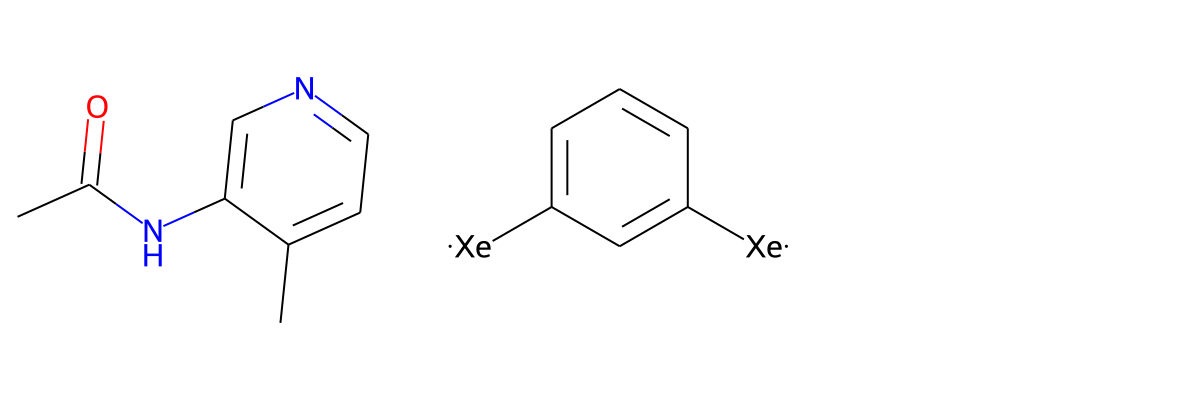

In [48]:
Draw.MolsToGridImage([mol_a, synthon_mols[synthon_to_print]], molsPerRow=3, subImgSize=(400, 400))

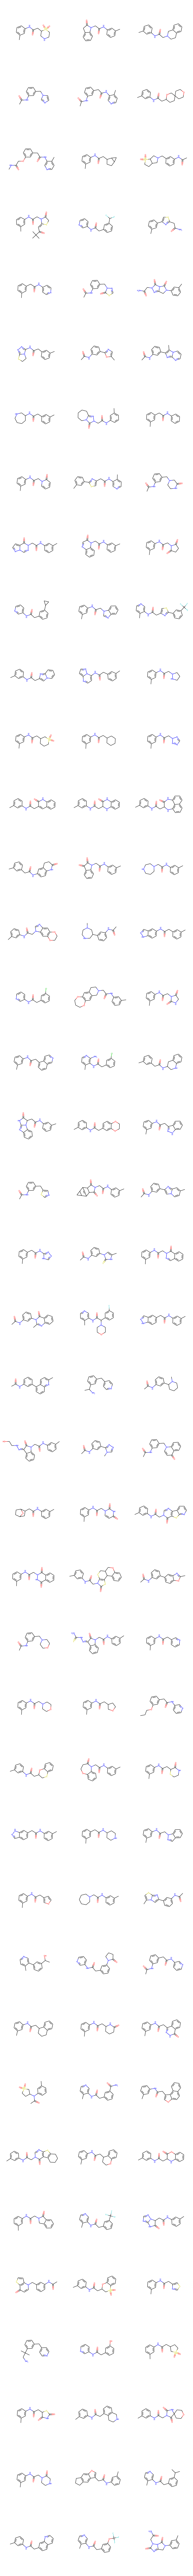

In [49]:
Draw.MolsToGridImage(mols_from_smiles(data[synthon_to_print]), molsPerRow=3, subImgSize=(400, 400), maxMols=120)

In [50]:
for s in data[synthon_to_print]:
    print(s)

Cc1cccc(NC(=O)CC2CNCCS2(=O)=O)c1
Cc1cccc(NC(=O)CN2C(=O)Cc3ccccc32)c1
Cc1cccc(NC(=O)CN2CCc3ccccc3C2)c1
CC(=O)Nc1cccc(Cn2ccnc2)c1
CC(=O)Nc1cccc(CC(=O)Nc2cnccc2C)c1
Cc1cccc(NC(=O)CC2CCC3(CCOCC3)CO2)c1
CNC(=O)COc1cccc(CC(=O)Nc2cnccc2C)c1
Cc1cccc(NC(=O)CC2CCC3CC23)c1
CC(=O)Nc1cccc(CN2CC3CCS(=O)(=O)C3C2)c1
Cc1cccc(NC(=O)CN2C(=O)CSC2=CC(=O)C(C)(C)C)c1
O=C(Cc1cccc(C(F)F)c1)Nc1cccnc1
Cc1cccc(-c2csc(CC(N)=O)n2)c1
Cc1cccc(CC(=O)Nc2ccncc2)c1
CC(=O)Nc1cccc(Cn2ncsc2=O)c1
Cc1cccc(N2Cc3nn(CC(N)=O)c(=O)n3C2=O)c1
Cc1cccc(CC(=O)Nc2nnc3n2CCS3)c1
CC(=O)Nc1cccc(-c2ncc(C)o2)c1
CC(=O)Nc1cccc(-c2nc3ncccn3c2C)c1
Cc1cccc(CC(=O)NC2CCCCNC2)c1
Cc1cccc(NC(=O)Cn2nc3n(c2=O)CCCCC3)c1
Cc1cccc(CC(=O)Nc2ccccc2)c1
Cc1cccc(NC(=O)Cn2ccccc2=O)c1
Cc1cccc(-c2nc(CC(=O)Nc3cnccc3C)cs2)c1
CC(=O)Nc1cccc(CN2CCNC(=O)C2)c1
Cc1cccc(NC(=O)Cn2ncn3nccc3c2=O)c1
Cc1cccc(NC(=O)Cn2c(=O)cnc3ccccc32)c1
Cc1cccc(NC(=O)CN2C(=O)CCC2=O)c1
O=C(Cc1cccc(C2CC2)c1)Nc1cccnc1
Cc1cccc(NC(=O)Cn2cnc3ccccc32)c1
Cc1ccncc1NC(=O)Cc1csc(-c2cccc(C(F)(F)F)c2)n1
Cc1cc

In [51]:
#driver.close()